In [75]:
import os, datetime
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from IPython import display

mpl.rcParams['figure.figsize'] = (16, 5)
mpl.rcParams['axes.grid'] = False

#dfn.plot(subplots=True)
#trainPercent = .7
tf.random.set_seed(13)
#--------------------------------------------------------------------------------
def get_data(dataset, target, start, end, history, target_size, skip=1,oneStep=False):
    data   = []
    labels = []

    start = start + history
    if end is None:
        end = len(dataset) - target_size

    for i in range(start, end):
        #print(f"++ {i}  {start} {end_index} \r", end="")
        indices = range(i-history, i, skip)
        
        dt = np.reshape(dataset[indices], ( -1, dataset.shape[-1]))
        data.append(dt)

        if oneStep:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

# target: column to predict
# history      : how long of history to look
# target_ahead : how much in the future "target" is predicted
#      =>confusing!! if values right next to it is predicted, it is =0
#      if say, you lke to predict 5 time steps aheads then it is 5
#
# single_oneStepstep : # predictions
# pct         : percentage split or a number of samples
def get_split(df, history,target=None, pct=0.7, 
                  target_ahead=0, skip=1, oneStep=True):

    TRAIN_SPLIT = int(len(df) * trainPercent) if (pct < 1) else pct
    target = target if target else df.columns[0]
    
    print(f"Training_split: {TRAIN_SPLIT}, target: {target}")
    
    scaler = StandardScaler()
    dfs = scaler.fit(df[:TRAIN_SPLIT])
    dfs.mean_, dfs.scale_
    dfns = (df-dfs.mean_)/dfs.scale_ 
    
    ds = dfns.values
    xtrn, ytrn = get_data(ds, dfns[target].values, 0, TRAIN_SPLIT,
                        history, target_ahead,skip,True)
    xval, yval = get_data(ds, dfns[target].values, TRAIN_SPLIT, None,
                        history, target_ahead,skip,True)
    
    return scaler, dfns, xtrn, ytrn, xval, yval


In [76]:
tar=dfn2.columns[0]
#get_data(dataset, target, start, end, history, target_size, skip=1,oneStep=False):
X, y = get_data(dfn2.values, dfn2[tar].values, 0, 100, 5, 4, skip=1,oneStep=False)
X[0:3], y[0:3], X.shape

(array([[[  -8.02,  996.52, 1307.75],
         [  -8.41,  996.57, 1309.8 ],
         [  -8.51,  996.53, 1310.24],
         [  -8.31,  996.51, 1309.19],
         [  -8.27,  996.51, 1309.  ]],
 
        [[  -8.41,  996.57, 1309.8 ],
         [  -8.51,  996.53, 1310.24],
         [  -8.31,  996.51, 1309.19],
         [  -8.27,  996.51, 1309.  ],
         [  -8.05,  996.5 , 1307.86]],
 
        [[  -8.51,  996.53, 1310.24],
         [  -8.31,  996.51, 1309.19],
         [  -8.27,  996.51, 1309.  ],
         [  -8.05,  996.5 , 1307.86],
         [  -7.62,  996.5 , 1305.68]]]), array([[-8.05, -7.62, -7.62, -7.91],
        [-7.62, -7.62, -7.91, -8.43],
        [-7.62, -7.91, -8.43, -8.76]]), (95, 5, 3))

In [77]:
dfn2

,T (degC),p (mbar),rho (g/m**3)
Date Time,,,
2009-01-01 00:10:00,-8.02,996.52,1307.75
2009-01-01 00:20:00,-8.41,996.57,1309.80
2009-01-01 00:30:00,-8.51,996.53,1310.24
2009-01-01 00:40:00,-8.31,996.51,1309.19
2009-01-01 00:50:00,-8.27,996.51,1309.00
...,...,...,...
2016-12-31 23:20:00,-4.05,1000.07,1292.98
2016-12-31 23:30:00,-3.35,999.93,1289.44
2016-12-31 23:40:00,-3.16,999.82,1288.39


In [78]:
from numpy import array
from numpy import hstack
from keras.preprocessing.sequence import TimeseriesGenerator
# define dataset
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95, 105])
# reshape series
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2))
#print(dataset)
generator2 = TimeseriesGenerator(dataset, in_seq1, length=2, batch_size=1)
print(f'Samples: {len(generator2)},')
print('batch --size=2')    
for i in range(len(generator2)):
    x, y = generator2[i]
    xx = [[list(c) for c in cc] for cc in x]
    yy = [list(c) for c in y]
    print(f'{xx} => {yy}')

Samples: 8,
batch --size=2
[[[10, 15], [20, 25]]] => [[30]]
[[[20, 25], [30, 35]]] => [[40]]
[[[30, 35], [40, 45]]] => [[50]]
[[[40, 45], [50, 55]]] => [[60]]
[[[50, 55], [60, 65]]] => [[70]]
[[[60, 65], [70, 75]]] => [[80]]
[[[70, 75], [80, 85]]] => [[90]]
[[[80, 85], [90, 95]]] => [[100]]


In [79]:
#get_data(dataset, target, start, end, history, target_size, skip=1,oneStep=False):
X, y = get_data(dataset, in_seq1, 0, 10, 5, 4, skip=1,oneStep=False)
X[0:3], y[0:3], X.shape

(array([[[10, 15],
         [20, 25],
         [30, 35],
         [40, 45],
         [50, 55]],
 
        [[20, 25],
         [30, 35],
         [40, 45],
         [50, 55],
         [60, 65]],
 
        [[30, 35],
         [40, 45],
         [50, 55],
         [60, 65],
         [70, 75]]]), array([array([[60],
        [70],
        [80],
        [90]]),
        array([[ 70],
        [ 80],
        [ 90],
        [100]]),
        array([[ 80],
        [ 90],
        [100]])], dtype=object), (5, 5, 2))

In [80]:
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
data = array([[i] for i in range(50)])
targets = array([[i] for i in range(50)])
data_gen = TimeseriesGenerator(data, targets,
                               length=10, sampling_rate=2,
                               batch_size=2)
'''assert len(data_gen) == 20
batch_0 = data_gen[0]
x, y = batch_0
assert np.array_equal(x,
                      np.array([[[0], [2], [4], [6], [8]],
                                [[1], [3], [5], [7], [9]]]))
assert np.array_equal(y,
                      np.array([[10], [11]]))

data.shape'''

for i in range(len(data_gen)):
    x, y = data_gen[i]
    xx = [[list(c) for c in cc] for cc in x]
    yy = [list(c) for c in y]
    print(f'{x} => {y}')
    print(f'{xx} => {yy}')
    break;

[[[0]
  [2]
  [4]
  [6]
  [8]]

 [[1]
  [3]
  [5]
  [7]
  [9]]] => [[10]
 [11]]
[[[0], [2], [4], [6], [8]], [[1], [3], [5], [7], [9]]] => [[10], [11]]


In [81]:
class TimeSeriesLSTM:
    '''
    df    : data frame
    UNITS1: # units in layer1 of LSTM
    UNITS2: # units in layer2 of LSTM, 0 if one layer
    nfeats: number of features
    target_ahead and npreds = how far ahead to predict, single or multiple
    '''
    def __init__(self, history, nfeats, target_ahead = 0, skip=1,
                 UNITS1=32, UNITS2=0, npreds=1, verbose=1,
                 OPTIMIZER = 'adam', model_file="temp.hd5"
                ):
        self.UNITS1       = UNITS1 or 32
        self.UNITS2       = UNITS2 or 0
        self.history      = history
        self.npreds       = npreds
        self.target_ahead = target_ahead
        self.model_file   = model_file
        self.skip         = skip
        
        self.nfeats       = nfeats
        self.BATCH_SIZE   = 256
        self.BUFFER_SIZE  = 10000
        self.EPOCHS       = 20
        self.LOSS         = "mae"
        self.OPTIMIZER    = tf.keras.optimizers.RMSprop(clipvalue=1.0)
        self.OPTIMIZER    = OPTIMIZER
        self.EVAL_INTERVAL= 200
        self.VAL_STEPS    = 50
        self.V            = verbose

    ''' This just builds a model '''
    def model(self):
        m = tf.keras.models.Sequential()
        
        hist =int(self.history/self.skip)
        m.add(LSTM(self.UNITS1, return_sequences= (self.npreds >1),
                        input_shape=(hist, self.nfeats) ))
        if(self.UNITS2):
            m.add(tf.keras.layers.LSTM(self.UNITS2, activation='relu'))
        m.add(tf.keras.layers.Dense(self.npreds))
        m.compile(optimizer = self.OPTIMIZER, loss=self.LOSS)
        
        self.model = m
        return m
    
    def prepare(self, dfn,target=None, pct=0.7):
        self.DFN    = dfn;
        self.target = target
        
        ret = get_split( dfn, self.history, target, pct,
                        self.target_ahead, self.skip,
                        oneStep = (self.npreds <= 1) )

        scaler, df, xtrn, ytrn, xval, yval = ret
        
        trn = tf.data.Dataset.from_tensor_slices((xtrn, ytrn))
        trn = trn.cache().shuffle(self.BUFFER_SIZE).batch(
                self.BATCH_SIZE).repeat()

        val = tf.data.Dataset.from_tensor_slices((xval, yval))
        val = val.batch(self.BATCH_SIZE).repeat()

        self.scaler, self.df, self.xtrn, self.ytrn,  \
                                self.xval, self.yval = ret
        self.trn, self.val = trn, val
        
        return self.DFN, self.skip, self.target, ret, trn, val
 
    def prepSet(self,prepped):
        self.DFN, self.skip, self.target, ret, self.trn, self.val = prepped
        self.scaler, self.df, self.xtrn, self.ytrn,  \
                                self.xval, self.yval = ret
    
    def fit(self, epochs=None, verbose=None):
        
        epochs = epochs  or self.EPOCHS
        verbose= verbose or self.V
        
        trn, val = self.trn, self.val
        self.model.fit(trn, verbose=verbose, epochs=epochs,
                steps_per_epoch = self.EVAL_INTERVAL,
                validation_data = val, validation_steps=self.VAL_STEPS,
                      callbacks=None)
        
    def save(self):
        self.model.save(self.model_file)

    def load(self):
        self.model = load_model(self.model_file)
        

In [89]:
def predictPlot_(start    , howmany, history      , npreds  ,
                 DFN      , model   , target_ahead , scaler, target, skip=1, title="",**kwargs):
    
    ds1   = DFN[start:start+howmany+history+target_ahead].values

    xp, yp = get_data(ds1, ds1[:, target], 0, None,
                         history, target_ahead, skip, npreds<=1)

    if (scaler is not None):
        for i,x  in enumerate(xp):
            xp[i] = scaler.transform(xp[i])

    yh1= model.predict(xp)
    yh = yh1
    if (scaler is not None):
        #yh = scaler.inverse_transform(yh1)
        yh = yh1 * scaler.scale_[target]
        yh = yh  + scaler.mean_[target]

    #print(xtrn[0], ytrn[0],dfn.iloc[0])
    target = dfn.columns[0]


    plt.plot(yp[:,0], marker=".", label = "y")
    plt.plot(yh, marker="x", label = "$\hat{y}$")
    for i in range (yh.shape[0]):
        pass
        #plt.plot(yh[:,i], marker="x", label= f"predicted: {i}")
    
    idx= DFN.index[start+history+target_ahead : start+howmany+history+target_ahead]
    intv = max(1, int(len(idx)/10) )
    plt.xticks(range(0,len(yh),10), idx, rotation=45)
    
    assert len(idx) == len(yp), "Hmmm Something calculations dont jibe!!!"
    
    plt.title(title)
    plt.grid(b="on")
    plt.legend()
    #pr = lstm.predict(xtrn[1].reshape(1,xtrn[0
    return xp,yp, yh, idx

In [83]:
if ("dfn1" not in globals()):
    csv_path = 'jena_climate_2009_2016.csv.zip'
    df = pd.read_csv(csv_path)
    df['Date Time'] = pd.to_datetime( df['Date Time'] )

    dfn1= df[['T (degC)']].copy()
    dfn1.index = df['Date Time']

    dfn2= df[['T (degC)', 'p (mbar)', 'rho (g/m**3)']].copy()
    dfn2.index = df['Date Time']

    dfn = dfn2
    dfn

Training_split: 300000, target: T (degC)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: temp.hd5/assets


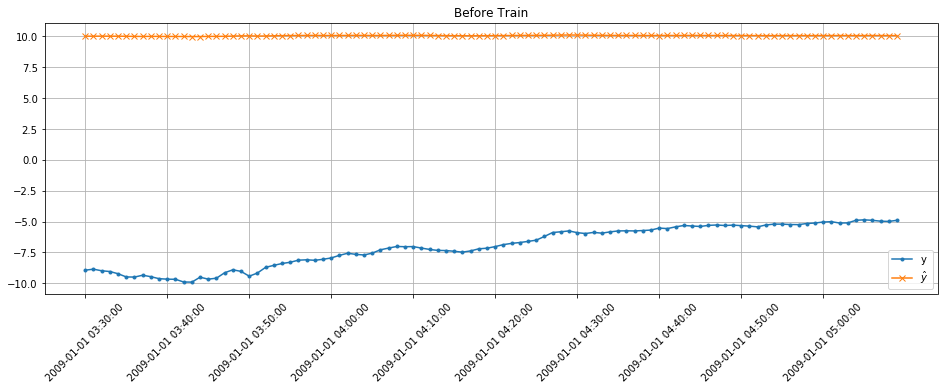

In [84]:
mpl.rcParams['figure.figsize'] = (16, 5)
mpl.rcParams['axes.grid'] = False

lmodel = TimeSeriesLSTM(history=20, nfeats=1, target_ahead=0, skip=1,
                 UNITS1=32, UNITS2=0, npreds=1, verbose=0)

lmodel.model()
preload=0
if (preload):
    lmodel.load()
    lmodel.prepSet(prep)
else:
    prep=lmodel.prepare(dfn1,0, 300000)
    lmodel.save()
    
predictPlot_(0, 100, title="Before Train", **vars(lmodel) );



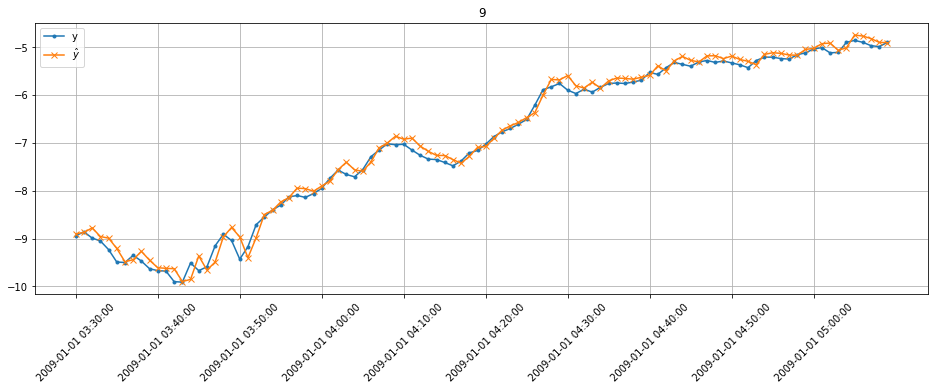

<Figure size 1152x360 with 0 Axes>

Train for 200 steps, validate for 50 steps
200/200 [==============================] - 2s 10ms/step - loss: 0.0153 - val_loss: 0.0127
++ time : 0:00:21.970770


<Figure size 1152x360 with 0 Axes>

In [86]:
t1 = datetime.datetime.now()
for i in range(10):
    display.clear_output(wait=True)
    plt.clf()
    predictPlot_(0, 100, title=f"{i}", **vars(lmodel) )
    plt.show()
    display.display(plt.gcf())
    lmodel.fit(1,1)
t2 = datetime.datetime.now()
print(f"++ time : {t2-t1}")

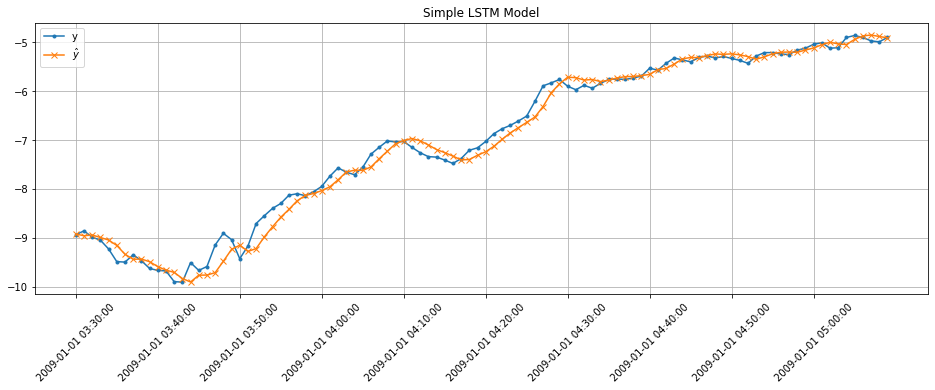

In [11]:
simple_lstm_model = load_model("simple_lstm_model.hd5")
predictPlot_(0, 100, 20,1,lmodel.DFN, simple_lstm_model, 0, lmodel.scaler, 0, 1,"Simple LSTM Model");


***
# MultiVariate Single Step Predictions

This uses multiple features dfn2 has 3 features we will use to train;
We will also predict temperature far ahead in the future say 12 hours ahead.

We will use 5 days of historical data with 3 features. Since temperature dont change often we down sample 
the entire data set to hours instead of 10 minutes

In [12]:
dfn2

,T (degC),p (mbar),rho (g/m**3)
Date Time,,,
2009-01-01 00:10:00,-8.02,996.52,1307.75
2009-01-01 00:20:00,-8.41,996.57,1309.80
2009-01-01 00:30:00,-8.51,996.53,1310.24
2009-01-01 00:40:00,-8.31,996.51,1309.19
2009-01-01 00:50:00,-8.27,996.51,1309.00
...,...,...,...
2016-12-31 23:20:00,-4.05,1000.07,1292.98
2016-12-31 23:30:00,-3.35,999.93,1289.44
2016-12-31 23:40:00,-3.16,999.82,1288.39


Training_split: 50000, target: T (degC)


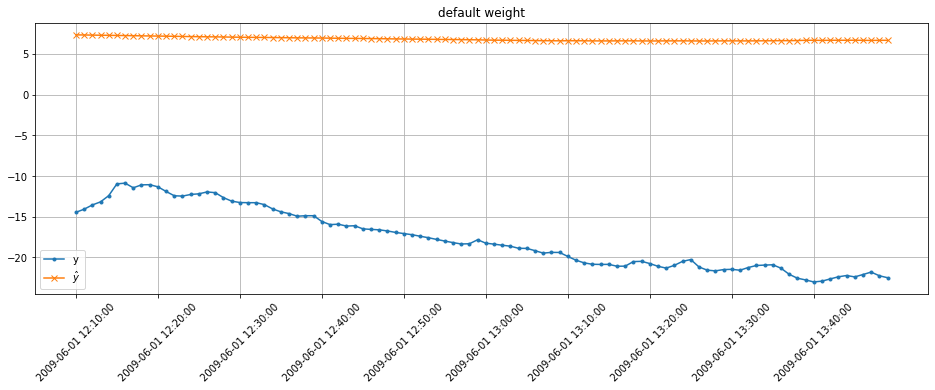

In [14]:
preload=0
lmodel1 = TimeSeriesLSTM(history=720, nfeats=3, target_ahead=72, UNITS1=32, UNITS2=0, npreds=1, skip=6, verbose=0)
lmodel1.model()

if (preload == 1):
    lmodel1.load()
    lmodel1.prepSet(prep)
elif(preload == 0):
    prep=lmodel1.prepare(dfn2,0,50000)
    #lmodel1.save()
    
predictPlot_(0, 100, title="default weight", **vars(lmodel1) );


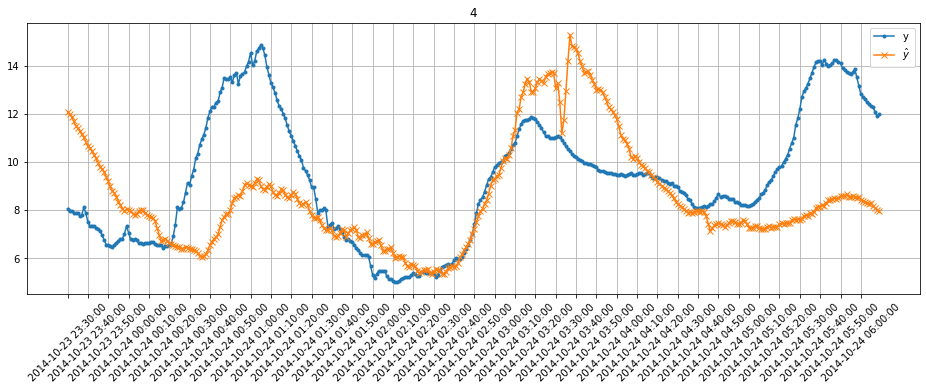

<Figure size 1152x360 with 0 Axes>

Train for 200 steps, validate for 50 steps
200/200 [==============================] - 11s 54ms/step - loss: 0.0561 - val_loss: 0.3918


''

<Figure size 1152x360 with 0 Axes>

In [41]:
for i in range(5):
    display.clear_output(wait=True)
    plt.clf()
    predictPlot_(305000, 400, title=f"{i}", **vars(lmodel1) )
    plt.show()
    display.display(plt.gcf())
    lmodel1.fit(1,1)
;

In [20]:
single_step_model = load_model("single_step_model.hd5")
#predictPlot_(0, 100, 720,1,lmodel1.df, lmodel1, 72, lmodel1.scaler, 0, "single_step_model");

#xp,yp,*_=predictPlot_(0, 100, 720, npreds=1, DFN=lmodel1.df, model=single_step_model, 
#                          target_ahead=72, scaler=None, target=0, skip=72, title="single_step_model");


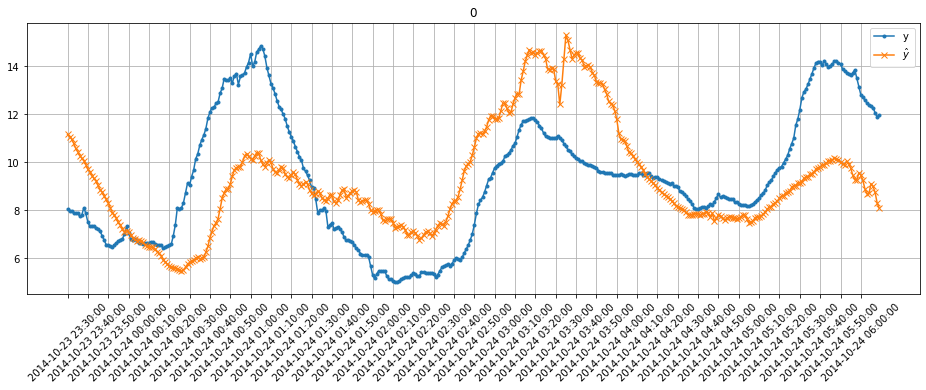

In [39]:
predictPlot_(305000, 400, title=f"{i}", **vars(lmodel1) );


***
# MultiVariate Multiple Steps Predictions

This uses multiple features dfn2 has 3 features we will use to train; We will also predict temperature far ahead in the future say 12 hours ahead.

We will use 5 days of historical data with 3 features. Since temperature dont change often we down sample the entire data set to hours instead of 10 minutes

In [87]:
preload=0
opt=tf.keras.optimizers.RMSprop(clipvalue=1.0)
lmodel2 = TimeSeriesLSTM(history=720, nfeats=3, target_ahead=72,UNITS1=32,UNITS2=16,npreds=12, skip=6, OPTIMIZER=opt)
lmodel2.model()

if (preload == 1):
    lmodel1.load()
    lmodel1.prepSet(prep)
elif(preload == 0):
    prep=lmodel2.prepare(dfn2,0,50000)
    #lmodel1.save()


Training_split: 50000, target: T (degC)


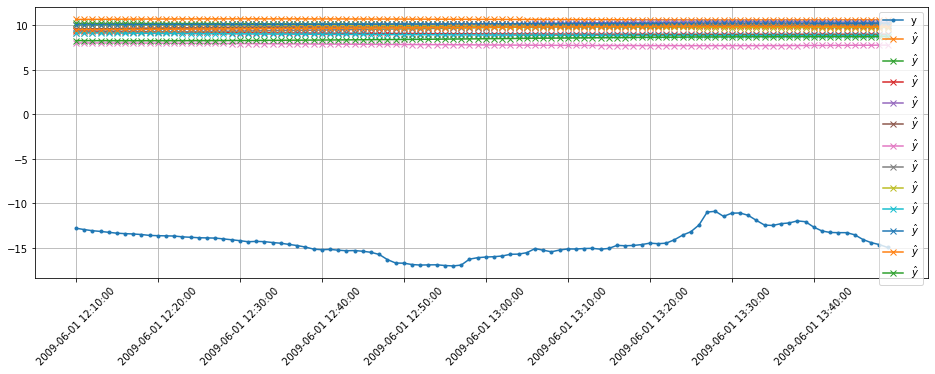

In [90]:

yh=predictPlot_(0, 100, **vars(lmodel2) );


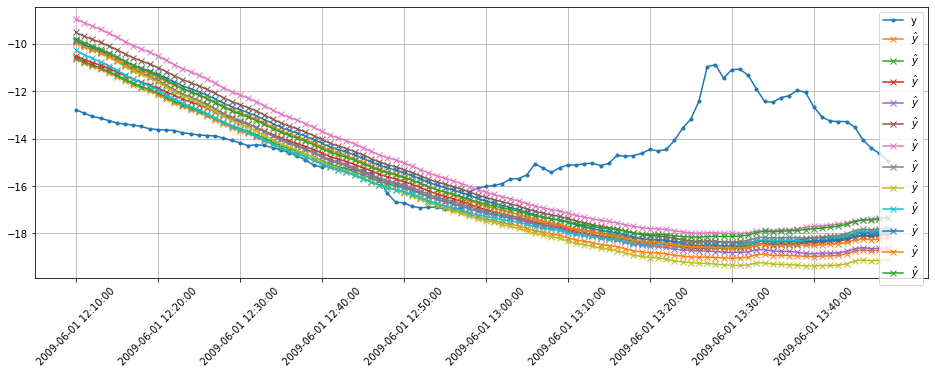

<Figure size 1152x360 with 0 Axes>

Train for 200 steps, validate for 50 steps
200/200 [==============================] - 19s 93ms/step - loss: 0.2400 - val_loss: 0.3643


''

<Figure size 1152x360 with 0 Axes>

In [91]:
for i in range(10):
    display.clear_output(wait=True)
    plt.clf()
    predictPlot_(0, 100, **vars(lmodel2) )
    plt.show()
    display.display(plt.gcf())
    lmodel2.fit(1,0)
;

In [92]:
m=lmodel2.model
m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 120, 32)           4608      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                204       
Total params: 7,948
Trainable params: 7,948
Non-trainable params: 0
_________________________________________________________________
